In [1]:
# Cluster patient states in the test set into 750 discrete cluster centroids.
# Assign test set points to the nearest cluster centroids

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.cluster import KMeans
import joblib

In [3]:
df = pd.read_csv('./dataset/sepsis_final_data_withTimes_newActions.csv')

In [4]:
# Remove outliers for observation features
for col in df.columns:
    if col.startswith('o:'):
        df[col] = df[col].clip(df[col].quantile(0.005), df[col].quantile(0.995))

In [5]:
train_traj = np.loadtxt('./data/traj_train.txt', dtype=int)
val_traj = np.loadtxt('./data/traj_val.txt', dtype=int)
test_traj = np.loadtxt('./data/traj_test.txt', dtype=int)

In [6]:
len(train_traj), len(val_traj), len(test_traj)

(13738, 2944, 2944)

In [7]:
df_train = df[df['traj'].isin(train_traj)]
df_val = df[df['traj'].isin(val_traj)]
df_test = df[df['traj'].isin(test_traj)]

In [8]:
# Specify which features to use
# All columns are numeric
# 5 demog/contextual features, 33 time-series
icustayid_col = 'm:icustayid'
dem_keep_cols = ['o:gender', 'o:mechvent', 'o:re_admission', 'o:age', 'o:Weight_kg']
obs_keep_cols = ['o:GCS', 'o:HR', 'o:SysBP',
       'o:MeanBP', 'o:DiaBP', 'o:RR', 'o:Temp_C', 'o:FiO2_1', 'o:Potassium',
       'o:Sodium', 'o:Chloride', 'o:Glucose', 'o:Magnesium', 'o:Calcium',
       'o:Hb', 'o:WBC_count', 'o:Platelets_count', 'o:PTT', 'o:PT',
       'o:Arterial_pH', 'o:paO2', 'o:paCO2', 'o:Arterial_BE', 'o:HCO3',
       'o:Arterial_lactate','o:PaO2_FiO2', 'o:SpO2', 'o:BUN', 'o:Creatinine',
       'o:SGOT', 'o:SGPT', 'o:Total_bili', 'o:INR']
cols = dem_keep_cols + obs_keep_cols

In [9]:
X_train = df_train[cols]
X_val = df_val[cols]
X_test = df_test[cols]

In [10]:
X_train.shape, X_val.shape, X_test.shape

((179451, 38), (38332, 38), (38790, 38))

In [13]:
kmeans_train = KMeans(n_clusters=750, random_state=0, n_init=10, verbose=10)

In [14]:
kmeans_train.fit(X_train)

Initialization complete
Iteration 0, inertia 3647485.9395674323.
Iteration 1, inertia 3078129.6407923056.
Iteration 2, inertia 2997328.374691205.
Iteration 3, inertia 2961155.169441487.
Iteration 4, inertia 2940113.507536587.
Iteration 5, inertia 2926232.359807137.
Iteration 6, inertia 2916111.5998630123.
Iteration 7, inertia 2908514.102920794.
Iteration 8, inertia 2902673.752951205.
Iteration 9, inertia 2897967.3379312954.
Iteration 10, inertia 2894051.278182437.
Iteration 11, inertia 2890702.9064623537.
Iteration 12, inertia 2888034.677527563.
Iteration 13, inertia 2885870.103906907.
Iteration 14, inertia 2883925.734872745.
Iteration 15, inertia 2882277.108872179.
Iteration 16, inertia 2880787.097955256.
Iteration 17, inertia 2879446.770675881.
Iteration 18, inertia 2878199.666300531.
Iteration 19, inertia 2877111.5282356753.
Iteration 20, inertia 2876124.570523129.
Iteration 21, inertia 2875282.8958249637.
Iteration 22, inertia 2874494.1552146478.
Iteration 23, inertia 2873733.70935

KMeans(n_clusters=750, n_init=10, random_state=0, verbose=10)

In [15]:
kmeans_train.inertia_

2859105.1515588565

In [21]:
import matplotlib.pyplot as plt
from collections import Counter

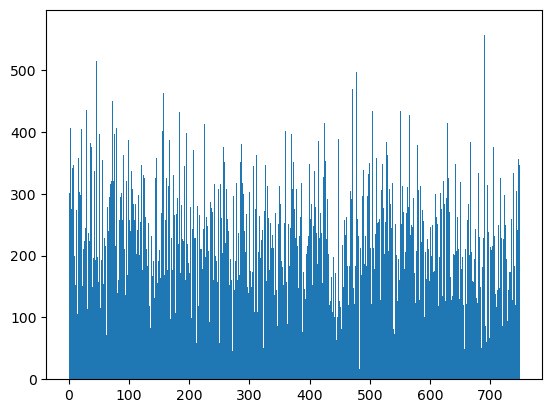

In [22]:
y_train = kmeans_train.predict(X_train)
plt.hist(y_train, bins=range(750))
plt.show()

In [25]:
c = Counter(y_train)
pd.Series(c.values()).describe()

count    750.000000
mean     239.268000
std       90.659261
min       16.000000
25%      176.000000
50%      231.000000
75%      298.750000
max      569.000000
dtype: float64

In [26]:
joblib.dump(kmeans_train, './data/kmeans_750.joblib')

['./data/kmeans_750.joblib']

In [27]:
df_train_final = df_train[['traj', 'step', 'm:icustayid', 'r:reward', 'a:action', 'a:vaso', 'a:iv']].copy()
df_train_final['s:state'] = kmeans_train.predict(X_train)

df_val_final = df_val[['traj', 'step', 'm:icustayid', 'r:reward', 'a:action', 'a:vaso', 'a:iv']].copy()
df_val_final['s:state'] = kmeans_train.predict(X_val)

df_test_final = df_test[['traj', 'step', 'm:icustayid', 'r:reward', 'a:action', 'a:vaso', 'a:iv']].copy()
df_test_final['s:state'] = kmeans_train.predict(X_test)

In [28]:
df_train_final.to_csv('./data/traj_data_train.csv', index=False)
df_val_final.to_csv('./data/traj_data_val.csv', index=False)
df_test_final.to_csv('./data/traj_data_test.csv', index=False)